In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning import Trainer
import torch.nn as nn
import torch
import torch.nn.functional as F
import albumentations.pytorch as A
from torch.utils.data import DataLoader
from albumentations import Resize, PadIfNeeded, Compose, Normalize, LongestMaxSize
from torch.utils.data import Dataset
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split
from skimage.transform import rotate, AffineTransform, warp
from tqdm.auto import tqdm
from pytorch_lightning import LightningModule, Trainer
from sklearn.metrics import mean_absolute_percentage_error
from torchvision.transforms.functional import to_pil_image
from torch import optim
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Пункт 1

In [2]:
def shift_image(image_path, interpolation=cv2.INTER_CUBIC):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Unable to open image at {image_path}")
        return None

    matrix = np.float32([[1, 0, 3.5], [0, 1, 3.5]])
    shifted = cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]), 
                             flags=interpolation, borderMode=cv2.BORDER_WRAP)

    return shifted


In [3]:
def process_images(src_dir, target_dir):
    if not os.path.isdir(src_dir):
        print(f"{src_dir} is not a directory")
        return

    os.makedirs(target_dir, exist_ok=True)

    image_paths = [os.path.join(src_dir, img) for img in os.listdir(src_dir) 
                   if os.path.isfile(os.path.join(src_dir, img))]

    for img_path in image_paths:
        shifted = shift_image(img_path)
        if shifted is not None:
            cv2.imwrite(os.path.join(target_dir, os.path.basename(img_path)), shifted)
    
    print(f"All images have been successfully shifted and saved in {target_dir}")


Наивный тест функций

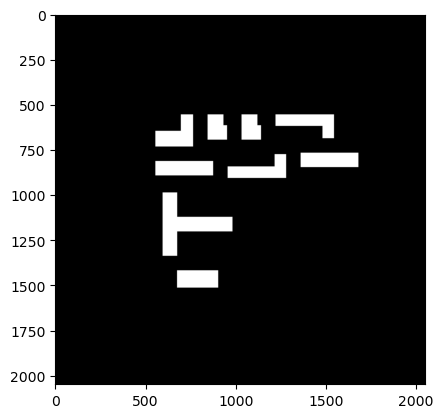

In [4]:
img_path = "/kaggle/input/data-wb/dataset/src/100_0.png"
sh_im = shift_image(img_path)
plt.imshow(cv2.cvtColor(sh_im, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
#process_images(src_dir=r"C:\Users\User\Downloads\dataset\dataset\src", target_dir=r"C:\Users\User\Downloads\dataset\dataset\dst")

### Пункт 2

In [6]:
def create_dataset(src_dir, dst_dir, test_size=0.2):
    src_image_paths = [os.path.join(src_dir, img) for img in os.listdir(src_dir) 
                       if os.path.isfile(os.path.join(src_dir, img))]
    dst_image_paths = [os.path.join(dst_dir, img) for img in os.listdir(dst_dir) 
                       if os.path.isfile(os.path.join(dst_dir, img))]

    if len(src_image_paths) != len(dst_image_paths):
        print("The number of images in src_dir does not match the number of images in dst_dir")
        return

    image_pairs = list(zip(src_image_paths, dst_image_paths))
    train_pairs, test_pairs = train_test_split(image_pairs, test_size=test_size)

    return train_pairs, test_pairs


In [7]:
data = create_dataset(
    src_dir="/kaggle/input/data-wb/dataset/src",
    dst_dir="/kaggle/input/data-wb/dataset/dst"
)

In [8]:
class PairedImageDataset(Dataset):
    def __init__(self, image_pairs, transform=None):
        self.image_pairs = image_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        img_name1, img_name2 = self.image_pairs[idx]

        image1 = cv2.imread(img_name1)
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
        image1 = image1.astype(np.float32) / 255.0

        image2 = cv2.imread(img_name2)
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
        image2 = image2.astype(np.float32) / 255.0

        if self.transform:
            image1 = self.transform(image=image1)["image"]
            image2 = self.transform(image=image2)["image"]

        return image1, image2


In [9]:
torch.cuda.empty_cache()

### Пункты 3-4

In [10]:
import os
transform = Compose([
    LongestMaxSize(max_size=224),
    PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    ToTensorV2(),
])

train_data, test_data = create_dataset(
    src_dir="/kaggle/input/data-wb/dataset/src",
    dst_dir="/kaggle/input/data-wb/dataset/dst"
)

train_dataset = PairedImageDataset(train_data, transform=transform)
test_dataset = PairedImageDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [11]:
img_path = "/kaggle/input/data-wb/dataset/src/100_0.png"
image = Image.open(img_path).convert('RGB')

transform = Compose([
    LongestMaxSize(max_size=224),
    PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    ToTensorV2(),
])

# image_tensor = transform(image).unsqueeze(0).to(device)

# shiftnet_model = ShiftNet() 
# shiftnet_model = shiftnet_model.to(device)
# shiftnet_model.eval() 

# with torch.no_grad():
#     transformed_image_tensor = shiftnet_model(image_tensor)

# image_display = image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
# transformed_image_display = transformed_image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

# image_shift_ = Image.open("/kaggle/input/data-wb/dataset/dst/100_0.png").convert('RGB')
# image_tensor_ = transform(image_shift_).unsqueeze(0).to(device)
# image_shift = image_tensor_.squeeze().cpu().permute(1, 2, 0).numpy()

# fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# ax[0].imshow(image_display)
# ax[0].axhline(image_display.shape[0] / 2, color='r')
# ax[0].axvline(image_display.shape[1] / 2, color='r')
# ax[0].set_title("Original Image")

# ax[1].imshow(transformed_image_display)
# ax[1].axhline(transformed_image_display.shape[0] / 2, color='r')
# ax[1].axvline(transformed_image_display.shape[1] / 2, color='r')
# ax[1].set_title("Transformed Image")

# # Отобразите фигуру
# plt.show()


In [12]:
import cv2
import numpy as np

def calculate_shift_error(image1, image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

    # Вычислим оптический поток
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    
    shift_error_x = np.mean(np.abs(flow[..., 0])) # Вычислим ошибку сдвига как среднее абсолютное значение оптического потока по соответствующим осям
    shift_error_y = np.mean(np.abs(flow[..., 1]))

    return 1/abs(np.log(shift_error_x)), 1/abs(np.log(shift_error_y))


In [53]:
@torch.no_grad()
def calculate_and_plot_shift_errors(model, transform, data):
    errors_x = []
    errors_y = []
    model.eval()

    for img_src_path, img_dst_path in data:
        image = Image.open(img_src_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)

        transformed_image_tensor = model(image_tensor)

        image_display = image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
        transformed_image_display = transformed_image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

        image_shift = Image.open(img_dst_path).convert('RGB')
        image_shift_tensor = transform(image_shift).unsqueeze(0).to(device)
        image_shift_display = image_shift_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

        shift_error_x, shift_error_y = calculate_shift_error(image_shift_display, transformed_image_display)
        errors_x.append(shift_error_x)
        errors_y.append(shift_error_y)

    # Построение гистограммы ошибок сдвига
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(errors_x, bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Shift X Errors')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    plt.hist(errors_y, bins=50, color='red', alpha=0.7)
    plt.title('Histogram of Shift Y Errors')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    errors_x = np.array(errors_x)
    errors_y = np.array(errors_y)

    print(f'Shift X Errors: Min {np.min(errors_x):.5f}, Max {np.max(errors_x):.5f}, Mean {np.mean(errors_x):.5f}, Std {np.std(errors_x):.5f}')
    print(f'Shift Y Errors: Min {np.min(errors_y):.5f}, Max {np.max(errors_y):.5f}, Mean {np.mean(errors_y):.5f}, Std {np.std(errors_y):.5f}')



In [121]:
class Net(nn.Module): # реализация модели stn для преобразований изображения
    def __init__(self):
        super(Net, self).__init__()

        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU()
        )
        self.fc_loc = nn.Sequential(
            nn.Linear(27040, 32),
            nn.ReLU(),
            nn.Linear(32, 3 * 2)
        )
        
        self.fc_loc[2].weight.data.zero_() 
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float)) # Инициализация весов тождественного преобразования

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 27040)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)
        return x

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)


In [123]:
class WGLoss(nn.Module):
    def __init__(self, white_weight=3.0, gray_weight=1.0, threshold=0.01, eps=1e-6):
        super(ImprovedCustomLoss, self).__init__()
        self.white_weight = white_weight
        self.gray_weight = gray_weight
        self.mse_loss = nn.MSELoss(reduction='none')
        self.threshold = threshold
        self.eps = eps 

    def forward(self, output, target):
        mse_loss = self.mse_loss(output, target)

        output_grad = torch.abs(output[:, :, :-1, :-1] - output[:, :, 1:, 1:])
        target_grad = torch.abs(target[:, :, :-1, :-1] - target[:, :, 1:, 1:])

        grad_loss = self.mse_loss(output_grad, target_grad)

        white_mask = (target[:, :, :-1, :-1] > self.threshold)
        gray_mask = (target[:, :, :-1, :-1] <= self.threshold) & (target[:, :, :-1, :-1] > 0)

        weighted_mse_loss = self.white_weight * mse_loss[:, :, :-1, :-1] * white_mask.float() + \
                            self.gray_weight * mse_loss[:, :, :-1, :-1] * gray_mask.float()

        weighted_grad_loss = self.white_weight * grad_loss * white_mask.float() + \
                             self.gray_weight * grad_loss * gray_mask.float()

        return weighted_mse_loss.mean() + weighted_grad_loss.mean() + self.eps




In [124]:
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ReduceLROnPlateau

class ShiftNetModule(pl.LightningModule):
    def __init__(self):
        super(ShiftNetModule, self).__init__()
        self.model = Net() 
        self.criterion =  WGLoss() 

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        data, target = batch
        output = self.model(data)
        loss = self.criterion(output, target)

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, target = batch
        output = self.model(data)
        loss = self.criterion(output, target)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3) 
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        return {
           'optimizer': optimizer,
           'lr_scheduler': {
               'scheduler': scheduler,
               'monitor': 'val_loss',
            }
        }


In [125]:
model = ShiftNetModule()
trainer = Trainer(max_epochs=12, devices=1)
trainer.fit(model, train_loader, val_loader)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

In [127]:
torch.save(model.state_dict(), 'best_model_weights.pth')

In [131]:
model = ShiftNetModule() 
model.load_state_dict(torch.load('/kaggle/working/best_model_weights.pth'))
model.eval()  


ShiftNetModule(
  (model): Net(
    (localization): Sequential(
      (0): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): ReLU()
    )
    (fc_loc): Sequential(
      (0): Linear(in_features=27040, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=6, bias=True)
    )
  )
  (criterion): ImprovedCustomLoss(
    (mse_loss): MSELoss()
  )
)

### Пункт 5

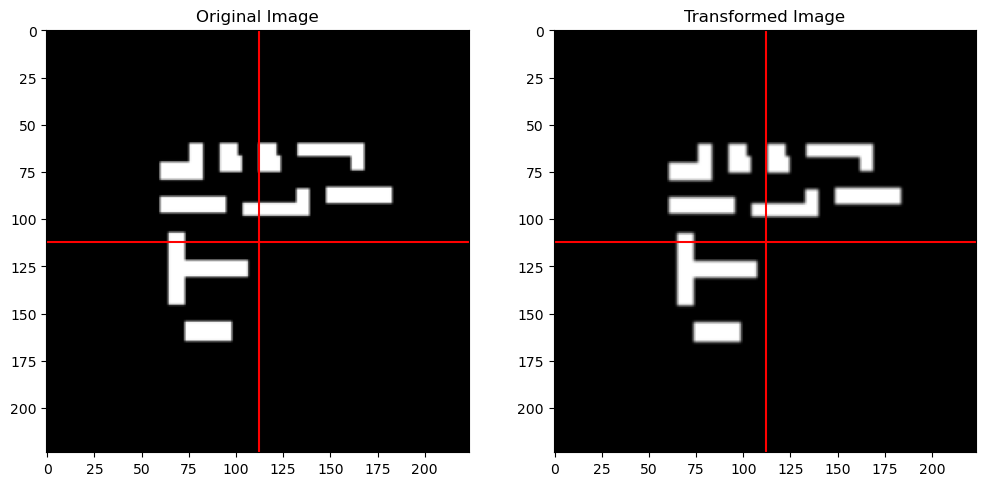

In [126]:
from PIL import Image
import torchvision.transforms as transforms

image = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0).to(device)

model.to(device)
model.eval()
with torch.no_grad():
    transformed_image_tensor = model(image_tensor)

image_display = image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()
transformed_image_display = transformed_image_tensor.squeeze().cpu().permute(1, 2, 0).numpy()

image_shift_ = Image.open("/kaggle/input/data-wb/dataset/dst/100_0.png").convert('RGB')
image_tensor_ = transform(image_shift_).unsqueeze(0).to(device)
image_shift = image_tensor_.squeeze().cpu().permute(1, 2, 0).numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_display)
ax[0].axhline(image_display.shape[0] / 2, color='r')
ax[0].axvline(image_display.shape[1] / 2, color='r')
ax[0].set_title("Original Image")

ax[1].imshow(transformed_image_display)
ax[1].axhline(transformed_image_display.shape[0] / 2, color='r')
ax[1].axvline(transformed_image_display.shape[1] / 2, color='r')
ax[1].set_title("Transformed Image")

plt.show()


In [128]:
shift_error_x, shift_error_y = calculate_shift_error(image_shift, transformed_image_display)
print(f"Shift X error: {shift_error_x}, Shift Y error: {shift_error_y} ")


Shift X error: 0.07666129844957273, Shift Y error: 0.07426633753399378 


In [129]:
shift_error_x, shift_error_y = calculate_shift_error(image_shift, image_display)
print(f"Shift X error: {shift_error_x}, Shift Y error: {shift_error_y} ")

Shift X error: 0.08774411136175853, Shift Y error: 0.08774889884578184 


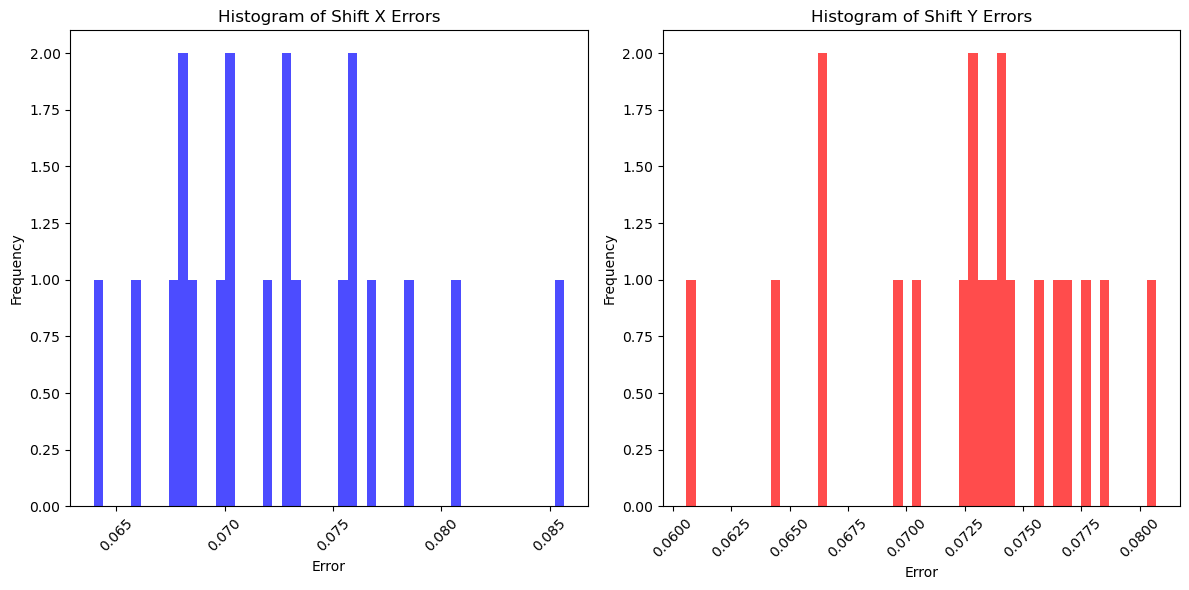

Shift X Errors: Min 0.06397, Max 0.08565, Mean 0.07261, Std 0.00520
Shift Y Errors: Min 0.06058, Max 0.08071, Mean 0.07259, Std 0.00491


In [130]:
calculate_and_plot_shift_errors(model, transform, data[1])

In [79]:
import ipywidgets as widgets
from IPython.display import display

img1 = image_shift  
img2 = transformed_image_display  

slider_x = widgets.IntSlider(min=1, max=img1.shape[1], step=1)
slider_y = widgets.IntSlider(min=1, max=img1.shape[0], step=1)
slider_size = widgets.IntSlider(min=1, max=50, step=1)

out1 = widgets.Output()
out2 = widgets.Output()

def on_value_change(change):
    x = slider_x.value
    y = slider_y.value
    size = slider_size.value
    
    x_start = max(0, x - size // 2)
    x_end = min(img1.shape[1], x + size // 2)
    
    y_start = max(0, y - size // 2)
    y_end = min(img1.shape[0], y + size // 2)
    
    with out1:
        out1.clear_output(wait=True)
        plt.imshow(img1[y_start:y_end, x_start:x_end], cmap='gray')
        plt.show()
    with out2:
        out2.clear_output(wait=True)
        plt.imshow(img2[y_start:y_end, x_start:x_end], cmap='gray')
        plt.show()

slider_x.observe(on_value_change, names='value')
slider_y.observe(on_value_change, names='value')
slider_size.observe(on_value_change, names='value')

display(slider_x, slider_y, slider_size, out1, out2)

IntSlider(value=1, max=224, min=1)

IntSlider(value=1, max=224, min=1)

IntSlider(value=1, max=50, min=1)

Output()

Output()